# 1. Setup

## 1.1 Import Drivers

In [1]:
import logging
from logging import getLogger
import sys
import pynq
import time
from pynq import PL
import os, time

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

from pynq import Overlay
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.drivers.ppssync import *
from mkidgen3.server.feedline_config import *
from mkidgen3.util import setup_logging
from mkidgen3.server.waveform import WaveformFactory

# 1.1.1 Set Board Timezone

In [2]:
os.environ['TZ'] = 'right/UTC'
time.tzset()

## 1.2 Setup Logging, Clocking, and Download Overlay

In [3]:
#setup_logging('feedlinereadoutserver');

In [73]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/gen3_top_eng6.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='external')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()
ol.rfdc.enable_mts()

In [74]:
ol.ip_dict['trigger_system/postage_maxi_0']['type']

'mazinlab:mkidgen3:postage_maxi:0.3'

In [75]:
ol.ip_dict['trigger_system/postage_filter_0']['type']

'mazinlab:mkidgen3:postage_filter_w_interconn:0.1'

## 1.2.1 Start PPS SYNC

In [5]:
loop=asyncio.new_event_loop()
future=ol.pps_synchronization.pps_synchronizer_con_0.start_engine(PPSMode.FORCE_START, skew = 1000*1000*1000)
task = loop.create_task(future)
loop.run_until_complete(task)
loop.close()

# 2. Digital Demod Test

## 2.1 Play Waveform

In [6]:
tones = np.array([250.0e6 + 107e3, 2.00062500e+08])
amplitudes = np.full(tones.size, fill_value=0.8/tones.shape[0])

In [7]:
waveform = WaveformConfig(waveform=WaveformFactory(frequencies=tones, amplitudes=amplitudes, maximize_dynamic_range=False))

In [8]:
ol.dac_table.configure(**waveform.settings_dict())

## 2.2 ADC Capture

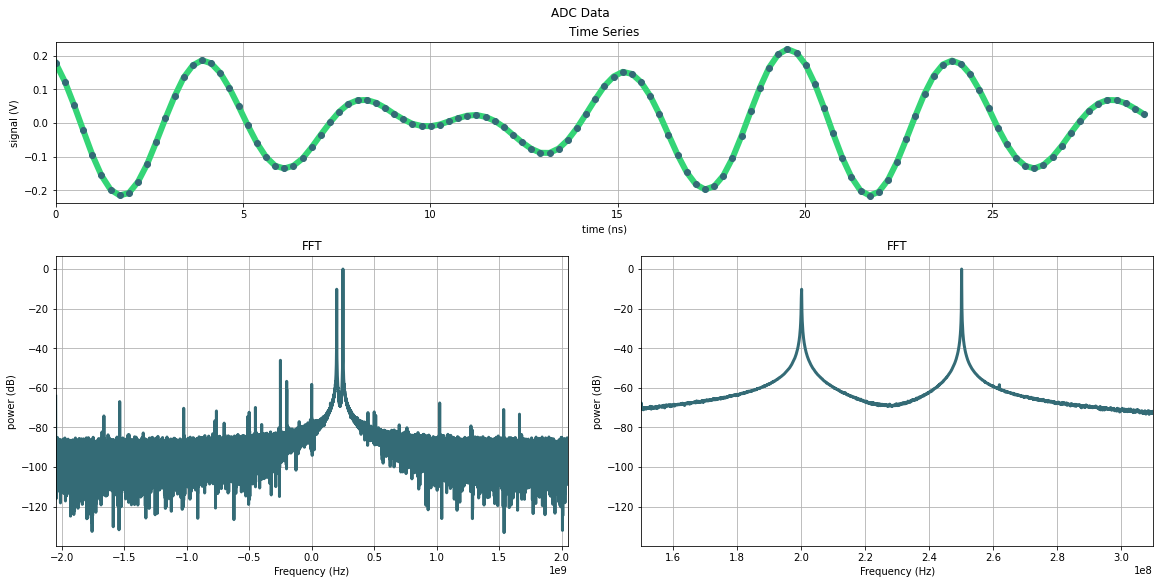

In [9]:
# Trigger Capture
ol.capture.capture_adc(2**19, complex=True) # throw away capture to clear any startup garbage
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (1.5e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)
del adc_capture_data

## 2.3 DDC Test

### 2.3.1 Assign Resonator Channels

In [10]:
chan = waveform.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

### 2.3.2 Program DDC

In [11]:
ddc_tones = np.zeros(2048)
ddc_tones[:tones.size]=tones
ol.photon_pipe.reschan.ddccontrol_0.configure(tones=ddc_tones)

### 2.3.3 DDC Capture Compare

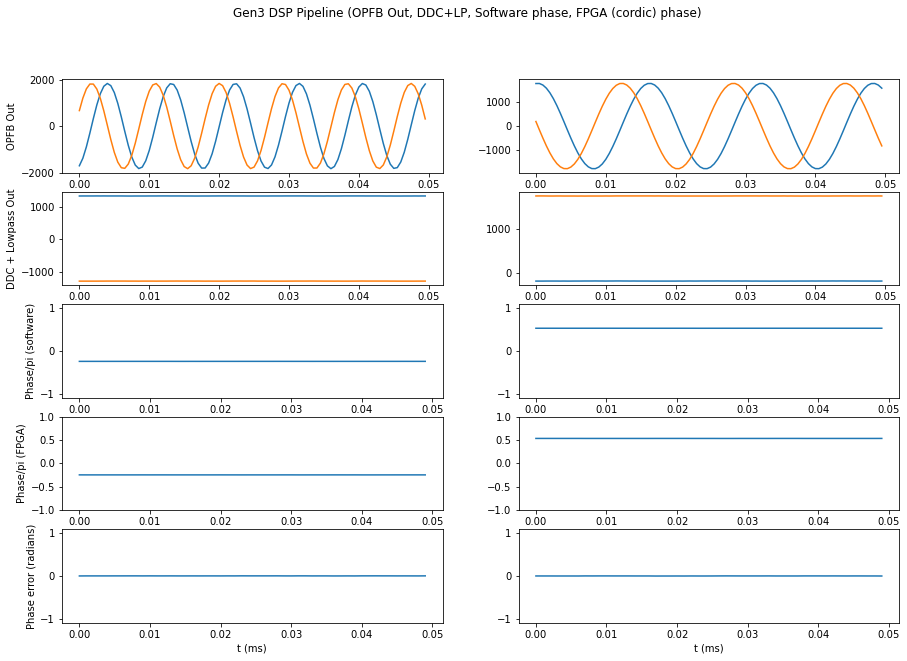

In [12]:
riq, iq = ol.capture.ddc_compare_cap()
iq, phase = ol.capture.cap_cordic_compare()
tonesplt = tones
chan_plt=[0,1]
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tonesplt, ssr_raw_order=True), ssr_order=True)
fig, axes = plt.subplots(5,len(chan_plt), figsize=(15,10))
tones_khz=g3.drivers.ddc.tone_increments(tonesplt, quantize=True)*1e3
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plot_waveforms(riq[:100, i], 2e6, mode='iq', ax=ax[0], label='OPFB Out' if not j else '')
    plot_waveforms(iq[:100, i], 2e6, mode='iq', ax=ax[1], label='DDC + Lowpass Out' if not j else '')
    plot_waveforms(iq[:50, i], 1e6, mode='sw_phase', ax=ax[2], label='Phase/pi (software)' if not j else '')
    plot_waveforms(phase[:50, i]/2**15, 1e6, mode='phase', ax=ax[3], label='Phase/pi (FPGA)' if not j else '')
    plt.ylim([-1,1])
    err=np.angle(iq[:50, i])-np.pi*phase[:50, i]/2**15
    plot_waveforms(err, 1e6, mode='phase', ax=ax[4], label='Phase error (radians)' if not j else '')
    #plt.ylim([-1,1])
plt.suptitle('Gen3 DSP Pipeline (OPFB Out, DDC+LP, Software phase, FPGA (cordic) phase)');
del riq, iq, phase

### 2.3.4 Test Centering

In [13]:
# Load Zeros and Capture Uncentered Data
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, centers)
_, iq_uncentered = ol.capture.ddc_compare_cap()

In [14]:
# Define Centers
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
centers[0:3] = [0+0.5*1j, 0-0.5*1j, 0.5+0*1j]

In [15]:
# Program Centers and Capture
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, centers)
_, iq_centered = ol.capture.ddc_compare_cap()

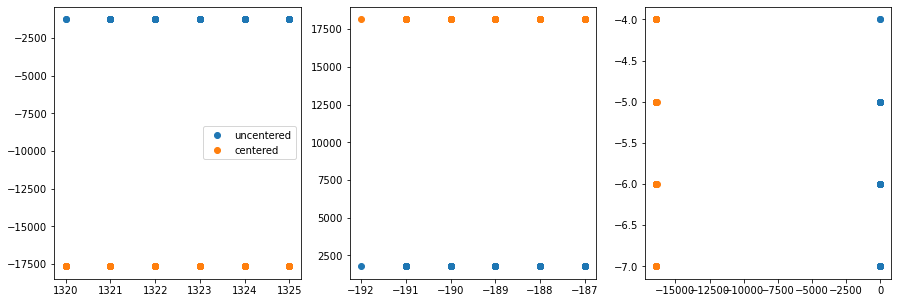

In [16]:
# Plot Results
chan_plt=[0,1,2]
fig, axes = plt.subplots(1,len(chan_plt), figsize=(15,5))
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    ax.plot(iq_uncentered[:,i].real, iq_uncentered[:,i].imag, "o", label="uncentered")
    ax.plot(iq_centered[:,i].real, iq_centered[:,i].imag, "o", label="centered")
    if j==0:
        ax.legend()
del iq_uncentered, iq_centered, _

In [17]:
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, centers)

# 3 Test Photon Capture

## 3.1 Create Synthetic Photons

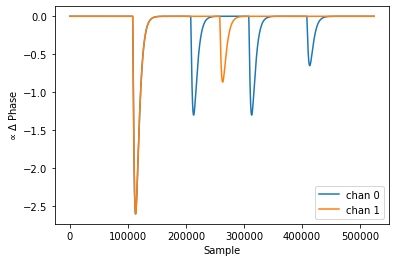

In [18]:
if not os.path.exists("pulse.npy"):
    # Generate a timestream proportional to the change in quasiparticle density
    quasiparticle_timestream = QuasiparticleTimeStream(fs = 4.096e9, ts = (2**19)/4.096e9)
    # Define a sudden change in quasiparticle density (caused by a photon)
    quasiparticle_timestream.gen_quasiparticle_pulse(tf=100) # 30 is realistic
    quasiparticle_timestream.data[quasiparticle_timestream.data.shape[0]//4:quasiparticle_timestream.data.shape[0]//4 + quasiparticle_timestream.photon_pulse.shape[0]] = quasiparticle_timestream.photon_pulse

    # Create resonator and compute S21
    resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1) #1e2
    rf = RFElectronics(gain=(3.0, 0, 0), phase_delay=0, cable_delay=50e-9)
    freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)

    plt.figure()
    quasiparticle_timestream.photon_pulse.shape
    plt.plot(quasiparticle_timestream.data)

    plt.figure()
    lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)
    theta1, d1 = lit_res_measurment.basic_coordinate_transformation()

    plt.plot(theta1)
    np.save("pulse.npy", theta1)

theta = np.load("pulse.npy")
theta[200_000:] += theta[:-200_000] / 2
theta[100_000:] += theta[:-100_000] / 2
theta2 = np.load("pulse.npy")
theta2[150_000:] += theta2[:-150_000] / 3
theta*=2*np.pi
theta2*=2*np.pi
plt.plot(theta, label='chan 0')
plt.plot(theta2, label='chan 1')
plt.xlabel('Sample')
plt.ylabel(r"$\propto \Delta$ Phase")
plt.legend(loc='lower right')

Inject `theta` modulation into the first tone and `theta2` into the second tone

In [19]:
phases = [-theta, -theta2]
waveform = WaveformConfig(waveform=WaveformFactory(frequencies=tones, amplitudes=amplitudes, 
                                                   phases=phases, maximize_dynamic_range=False))

## 3.2 Start DAC Playing Synthetic Photons

In [20]:
ol.dac_table.configure(**waveform.settings_dict())

## 3.3 Look at Photons with Phase Capture

In [21]:
_, phase = ol.capture.cap_cordic_compare(2**8)

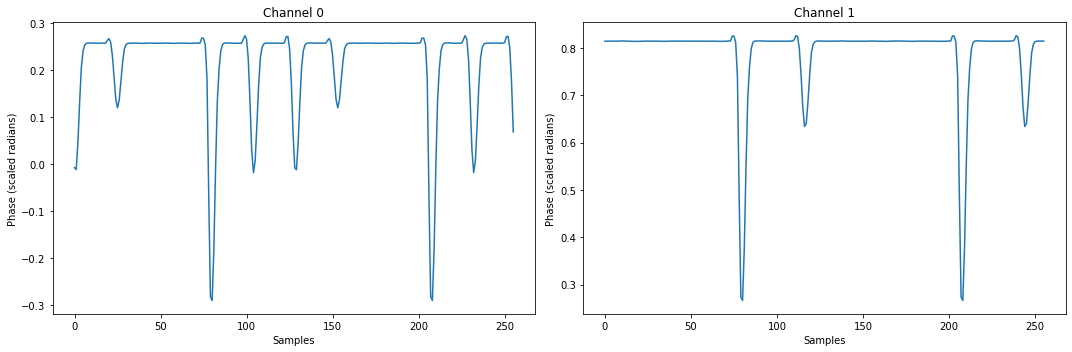

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(phase[:, 0]/2**15)
ax1.set_xlabel("Samples")
ax1.set_ylabel('Phase (scaled radians)')
ax1.set_title('Channel 0')
ax2.plot(phase[:, 1]/2**15)
ax2.set_xlabel("Samples")
ax2.set_ylabel('Phase (scaled radians)')
ax2.set_title('Channel 1')
plt.tight_layout()
#del phase, _

## 3.5 Program Matched Filter

In [23]:
filtercfg=FilterConfig(coefficients=f'unity{tones.size}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

In [24]:
## RAW
phases={}
n_points=1024
x = ol.capture.capture_phase(n_points, [0,1], tap_location='rawphase')
phases['raw']=np.array(x)
x.freebuffer()

# Capture
x = ol.capture.capture_phase(n_points, 'all', tap_location='phase')
phases['unity']=np.array(x)
x.freebuffer()

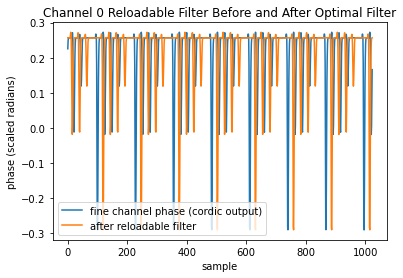

In [25]:
channel = 0
plt.plot(phases['raw'][:,channel]/(2**15-1))
plt.plot((phases['unity'][::,channel])/(2**15-1))
# plt.ylim([-1,1]);
plt.xlabel('sample')
plt.ylabel('phase (scaled radians)')
plt.legend(['fine channel phase (cordic output)', 'after reloadable filter'])
plt.title('Channel 0 Reloadable Filter Before and After Optimal Filter');
del phases

## 3.6 Bias Phase

In [26]:
# Make Sure DDC Has No Offset
phase_offsets = np.zeros(2048)
ddc_centers = np.zeros(2048, dtype=np.complex64)
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [27]:
# Capture Raw Phase with No Offsetx = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()

In [28]:
# Compute Phase Needed to Move Averge to Zero
raw_phase = phase/(2**15-1)
phase_offsets = np.zeros(2048)
phase_offsets[:tones.size] = -np.pi*raw_phase[:, :tones.size].mean(axis=0)
del phase, x

In [29]:
# Program DDC With New Offsets
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [30]:
# Capture Data
x = ol.capture.capture_phase(2**10, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()
moved_phase = phase/(2**15-1)

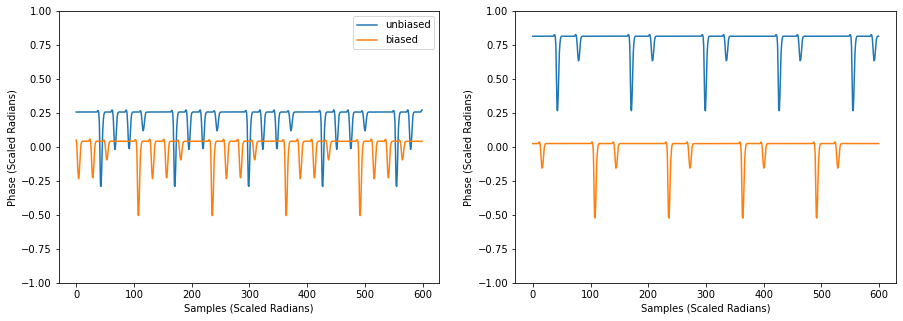

In [31]:
# Plot
chan_plt=[0,1]
fig, axes = plt.subplots(1, len(chan_plt), figsize=(15,5))
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plt.sca(ax)
    plt.plot(raw_phase[:600,i], label='unbiased')
    plt.plot(moved_phase[:600,i], label='biased')
    plt.ylim(-1, 1)
    plt.ylabel('Phase (Scaled Radians)')
    plt.xlabel('Samples (Scaled Radians)')
    if j==0:
        ax.legend()
del raw_phase, moved_phase

##  3.7 Set Trigger Thresholds and Holdoffs

In [32]:
thresholds = -0.32*np.ones(2048)
thresholds[1] = -0.42
thresholds[2:] = -0.99
holdoffs = np.full(2048, fill_value=20, dtype=np.uint16)

In [43]:
x = ol.capture.capture_phase(2**10, [0,1], tap_location='rawphase')
phase = np.array(x)/(2**15-1)
x.freebuffer()

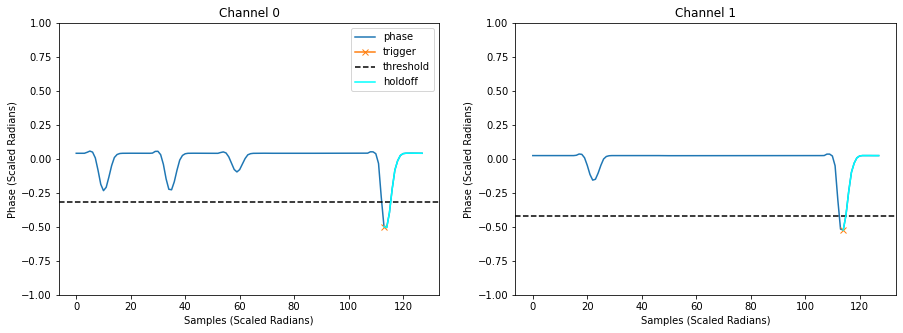

In [44]:
# Visualize Thresholds and Holdoffs
chan_plt=[0,1]
fig, axes = plt.subplots(1, len(chan_plt), figsize=(15,5))
samples = np.arange(128)
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    trig = phase[:128,i]<thresholds[i]
    holdoff = slice(samples[trig][i], samples[trig][i]+holdoffs[i])
    plt.sca(ax)
    plt.plot(samples, phase[:128,i], label='phase')
    plt.plot(samples[trig][i], phase[:128,i][trig][i], marker='x', label='trigger')
    plt.axhline(thresholds[i], linestyle='--', color='black', label='threshold')
    plt.plot(samples[holdoff], phase[:128,i][holdoff], color='cyan', label='holdoff')
    plt.title(f'Channel {i}')

    plt.ylim(-1, 1)
    plt.ylabel('Phase (Scaled Radians)')
    plt.xlabel('Samples (Scaled Radians)')
    if j==0:
        ax.legend()
del phase

In [35]:
ol.trigger_system.trigger_1.configure(thresholds, holdoffs)

In [36]:
n_photons = 2 # number of photons trigger across channels each dac replay cycle
expected_rate = 4.096e9/2**19 *n_photons  # per pulse below threshold

## Postage Stamp

In [37]:
def process_postage(buffer, floating=True, omit_first=True):
    """
    convert postage stamp capture data into rids and associated complex values, 
    by default omit the first, garbage stamp
    """
    if isinstance(buffer, pynq.buffer.PynqBuffer):
        buffer = np.array(buffer)
    # first photon is generally garbage
    start=int(omit_first)
    d=(buffer[start:,1:,0]+buffer[start:,1:,1]*1j)/(2**15-1)
    rid = buffer[start:,0,0]
    return rid, d

In [38]:
ol.trigger_system.postage_filter_0.configure(monitor_channels=[0,1,2,3,4,5,6,7])

In [45]:
d=ol.trigger_system.postage_maxi_0.capture() # caputres 8000 events
time.sleep(8000/expected_rate*1.01*2)
ol.trigger_system.postage_maxi_0.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=1, RESERVED_3=0),
  GIER = Register(Enable=1, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=1, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=1, CHAN1_INT_ST=0, RESERVED_0=0),
  iq_1 = Register(iq=write-only),
  iq_2 = Register(iq=write-only),
  event_count = Register(event_count=8000, RESERVED=0),
  event_count_ctrl = Register(event_count_ap_vld=1, RESERVED=0),
  max_events = Register(max_events=write-only, RESERVED=write-only)
}

In [46]:
monitor_channels = ol.trigger_system.postage_filter_0.monitor_channels
rid, stamp = process_postage(d, floating=True)

In [61]:
monitor_channels

(0, 1, 2, 3, 4, 5, 6, 7)

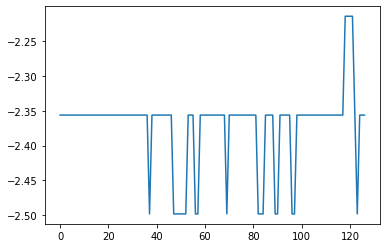

In [47]:
chan=1
plt.plot(np.angle(stamp[rid==chan][0]))

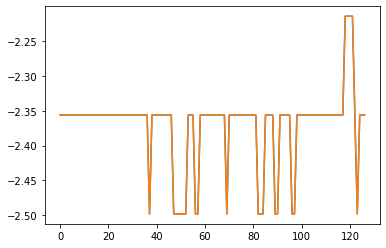

In [64]:
chan=1
plt.plot(np.angle(stamp[rid==0][0]))
plt.plot(np.angle(stamp[rid==1][0]))

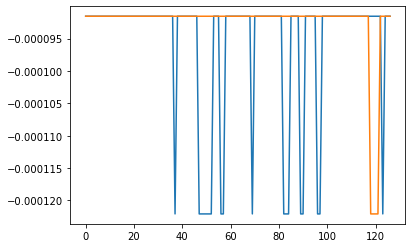

In [60]:
chan=1
plt.plot(np.real(stamp[rid==chan][0]))
plt.plot(np.imag(stamp[rid==chan][0]))

/tmp/ipykernel_1165/2193987361.py:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.abs(stamp[rid==chan][:200]), origin='lower')


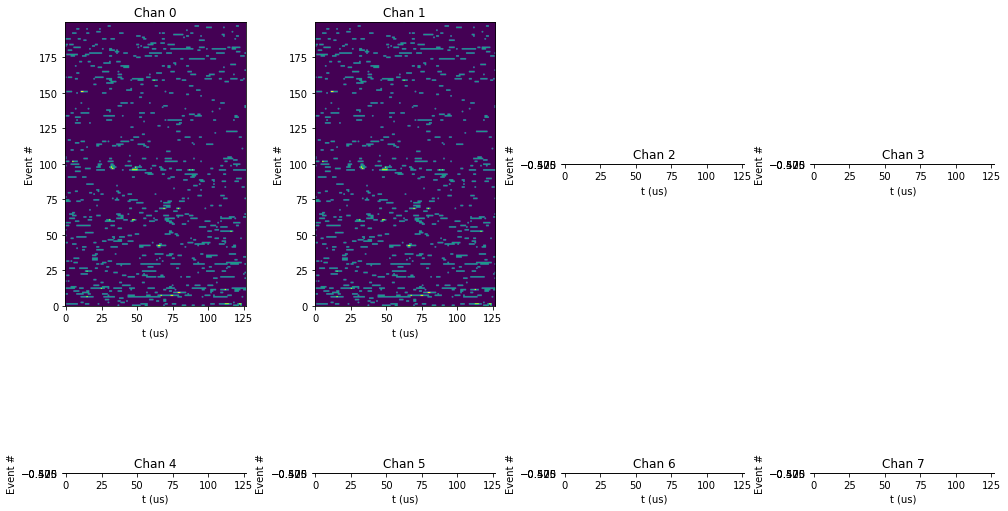

In [48]:
fig, ax = plt.subplots(2,4 , figsize=(14,10))
for i, (chan, ax) in enumerate(zip(monitor_channels, ax.ravel())):
    plt.sca(ax)
    plt.title(f'Chan {chan}')
    plt.imshow(np.abs(stamp[rid==chan][:200]), origin='lower')
    plt.ylabel('Event #')
    plt.xlabel('t (us)')
plt.tight_layout()

## Photon Capture

In [49]:
tsub=ol.trigger_system
self=ol.trigger_system.photon_maxi_0

In [50]:
MAX_PERMISSIBLE_PER_BUFFER = 2 ** 16 - 1  #photons, that is
MAX_PERMISSIBLE_PER_BUFFER/expected_rate, expected_rate

(4.19424, 15625.0)

In [51]:
tsub.photon_maxi_0.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  photons_out_1 = Register(photons_out=write-only),
  photons_out_2 = Register(photons_out=write-only),
  Memory_n_photons = Register(value=0),
  active_buffer = Register(active_buffer=0, RESERVED=0),
  active_buffer_ctrl = Register(active_buffer_ap_vld=0, RESERVED=0),
  photons_per_buf = Register(photons_per_buf=write-only, RESERVED=write-only),
  time_shift = Register(time_shift=write-only, RESERVED=write-only)
}

In [52]:
from mkidgen3.drivers.trigger import PhotonMAXI
class PixelMap:
    
    """ The attribute map_bins is a tuple of the pixel bin edges i.e. for histograms"""
    def __init__(self, map, nx, ny=0):
        """ 
        A Pixel to channel mapping
        
        nx: the number of x pixels
        ny: the number of y pixels, 0 if 1d
        map: is a 1 or 2d array channel id to pixel coordinate. 1d is for linear arrays or 
        single feedlines. Will be coerced to integer.
    
        """
        self.map = map.astype(int)
        self.nx=max(nx,1)
        self.ny=max(ny,0)
        assert (ny>0) == (map.ndim==2)
        maxn=self.map.max(axis=-1)
        ok =  maxn[0]<self.nx and maxn[1]<self.ny if ny else maxn<self.nx
        assert ok, "Mapped pixels out of bounds"

        if not ny:
            self.map_bins=(np.arange(self.nx+1,dtype=int), )
        else:
            self.map_bins=np.arange(self.nx+1,dtype=int), np.arange(self.ny+1, dtype=int)
                
class PhotonAccumulator:
    def __init__(self, max_ram=100, pixelmap:PixelMap=None, n_channels=None):
        """
        A tool to gather photons together without running out of ram and ease access 
        to timeseries, images, and other helpful metrics.
        
        max_ram: how much space to allow for photon storage
        pixelmap: and optional channel id to x or xy map, should be a nChan x 1 or 2 array positions 
        n_channels: optional shortcut if pixelmap not specified
        """
        assert bool(n_channels) ^ bool(pixelmap), 'Must specify n_channels xor pixelmap'
        self.ram_limit = max_ram  # MiB
        self.map = pixelmap if pixelmap else PixelMap(np.arange(n_channels, dtype=int), n_channels)
        self._data=np.zeros(self.ram_limit*1024**2//PhotonMAXI.PHOTON_DTYPE.itemsize, dtype=PhotonMAXI.PHOTON_DTYPE)
        self.n=0

    def __getitem__(self, n):
        """Get photons for channel n"""
        return self.data[self.data['id']==n]
        
    def accumulate(self, buffer, n):
        """Add some packed photons to the pot"""
        d=np.array(buffer[:n])
        drop=max(n-(self._data.size-self.n), 0)
        if drop:
            getLogger(__name__).debug(f'Memory used up, dropping {drop} old photons.')
            self._data[:self._data.size-drop]=self._data[drop:]
        PhotonMAXI.unpack_photons(buffer[:n], out=self._data, n=self.n)
        self.n+=n-drop
        
    @property
    def data(self):
        return self._data[:self.n]
    
    def image(self, timestep_us=None, rate=False):
        """ Build an image out of the current photon data, specify a timestep (in us) to make a timecube"""
        
        first, last = self.data['time'][[0,-1]]
        duration_s = (last-first)/1e6
        if first>=last:
            raise ValueError('Last photon time is not after the first!')
            
        if timestep_us:
            timebins = (np.arange(first, last+timestep_us, timestep_us, dtype=type(timestep_us)),)
        else:
            timebins = tuple()
        imbins = self.map.map_bins
    
        val = self.map.map[self.data['id']]
        val = (val,) if self.map.map.ndim==1 else (val[0], val[1])
        coord = val + (self.data['time'],) if timestep_us else val
        
        hist, _ = np.histogramdd(coord, bins=imbins+timebins, density=rate)
        if rate:
            hist*=self.n
            hist/=duration_s if timestep is None else 1e6

        return hist

In [53]:
from mkidgen3.drivers.trigger import WaitMode
accum = PhotonAccumulator(max_ram=250, n_channels=2048)

capture_dur_s = 10

tsub.photon_maxi_0.stop_capture()
time.sleep(2)
buf = tsub.photon_maxi_0.capture(buffer_time_ms=1000)
interval = tsub.photon_maxi_0.buffer_interval/1000. #to seconds
i=0

while capture_dur_s>0:
        slept=time.perf_counter()
        
        tsub.photon_maxi_0.wait(method=WaitMode.POLL)

        slept=time.perf_counter()-slept
        
        print(f'Waited {slept*1e3:.1f} ms for interrupt, reading occupancy & active buffer')
        
        cnta, cntb, ab_i = tsub.photon_maxi_0.mmio.array[8:11]  # about 66% faster that a pair of reads, about 64-140 us
        ab_i &= 0xff
        count = cnta if ab_i else cntb
        count &= 0x1ffff

        if i>=2: # first three aren't great
            slept=time.perf_counter()
            accum.accumulate(buf[0 if ab_i else 1], count)
            slept=time.perf_counter()-slept
            capture_dur_s-=interval
            print(f' Accumulated in {slept*1e3:.1f} ms')
            
        i+=1

tsub.photon_maxi_0.stop_capture()

Waited 993.6 ms for interrupt, reading occupancy & active buffer
Waited 1048.3 ms for interrupt, reading occupancy & active buffer
Waited 1048.2 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.0 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.0 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.2 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.0 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 A

In [54]:
phots=accum[1]
phots.size*12/1024**2 #MiB in channel 1

0.9375

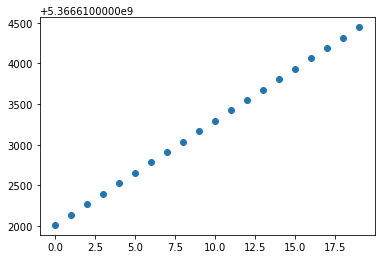

In [55]:
plt.plot(phots['time'][:20],"o")

In [56]:
slept=time.perf_counter()
x=accum.image(timestep_us=1000)
slept=time.perf_counter()-slept
print(f'Imaged in {slept*1e3:.1f} ms')

Imaged in 215.5 ms


In [58]:
x.shape,set(accum[1]['phase']/(2**15-1)), set(np.diff(accum[0]['time']))

((2048, 10486),
 {-0.5237281411175878,
  -0.5236671040986358,
  -0.5232703634754479,
  -0.5232398449659719},
 {128})

In [81]:
#No droped photons
set(np.diff(accum[0]['time']))=={128} # 1 photon on  chan 0

True

In [75]:
accum[0].size

81920